In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, merge, Flatten
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyti.exponential_moving_average import exponential_moving_average as ema
#Used TA-Lib for creating additional features. More on this later.
# from talib.abstract import *
# from talib import MA_Type

In [1]:
!pip install pyti

You are using pip version 10.0.1, however version 20.3.4 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [5]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [6]:
def resample_stock_data(df, timedelta):
    # make a copy
        df = df.copy()

        # convert index to datetime
        df.index = pd.to_datetime(df.index)

        # sort the index (evidently required by resample())
        df = df.sort_index()

        aggregation_dict = {
             'open': 'first', 
             'high': 'max',
             'low': 'min',
             'close': 'last',

        }

        rename_dict = {
            'open': 'open',
            'high': 'high',
            'low': 'low',
            'close': 'close',

        }


        return (df
          .resample(timedelta)
          .agg(aggregation_dict)
          .rename(columns=rename_dict)
        )

In [7]:
import pandas as pd
import numpy as np
data=pd.read_csv('bankniftyoneminutefinal.csv')

In [8]:
data['date_time']=pd.to_datetime(data['date'] + ' ' + data['time'])

In [9]:
data=data.drop('Unnamed: 6',axis=1)

In [10]:
data=data.set_index('date_time')

In [11]:
data_10=resample_stock_data(data,'10min')

In [12]:
data_10=data_10.dropna()

In [13]:
data_10.head()

,close,open,high,low
date_time,,,,
2015-01-09 09:10:00,18849.25,18845.90,18864.00,18790.2
2015-01-09 09:20:00,18815.15,18849.25,18859.65,18799.4
2015-01-09 09:30:00,18800.05,18815.15,18821.40,18772.9
2015-01-09 09:40:00,18779.40,18800.05,18814.25,18758.5
2015-01-09 09:50:00,18802.90,18783.05,18808.30,18761.1


In [14]:
DATA=data_10

In [17]:
DATA['hour'] = DATA.index.hour
DATA['day']  = DATA.index.weekday
DATA['week'] = DATA.index.week

DATA['close']  = pd.to_numeric(DATA['close'])
DATA['open']   = pd.to_numeric(DATA['open'])

DATA['avg_price']  = (DATA['low'] + DATA['high'])/2
DATA['range']      = DATA['high'] - DATA['low']
DATA['ohlc_price'] = (DATA['low'] + DATA['high'] + DATA['open'] + DATA['close'])/4
DATA['oc_diff']      = DATA['open'] - DATA['close']

# inputs = {
#     'open'   : DATA['open'].values,
#     'high'   : DATA['high'].values,
#     'low'    : DATA['low'].values,
#     'close'  : DATA['close'].values,
    
# }
DATA['ema'] = ema(DATA["close"], 15)
#DATA['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
DATA['bear_power'] = DATA['low'] - DATA['ema']
DATA['bull_power'] = DATA['high'] - DATA['ema']
# Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
DATA.dropna(inplace=True)
# Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
pca_input = DATA.drop('close',1).copy()
pca_features = pca_input.columns.tolist()
pca = PCA(n_components=1)
DATA['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

In [18]:
DATA.head()

,close,open,high,low,hour,day,week,avg_price,range,ohlc_price,oc_diff,ema,bear_power,bull_power,pca
date_time,,,,,,,,,,,,,,,
2015-01-09 13:50:00,18519.10,18578.00,18592.00,18493.80,13,4,2,18542.900,98.20,18545.7250,58.90,18590.966579,-97.166579,1.033421,-10946.168945
2015-01-09 14:00:00,18521.25,18519.10,18529.30,18479.65,14,4,2,18504.475,49.65,18512.3250,-2.15,18578.798979,-99.148979,-49.498979,-11035.747070
2015-01-09 14:10:00,18547.20,18521.25,18547.20,18490.60,14,4,2,18518.900,56.60,18526.5625,-25.95,18571.767509,-81.167509,-24.567509,-11014.247070
2015-01-09 14:20:00,18541.55,18547.20,18571.75,18524.70,14,4,2,18548.225,47.05,18546.3000,5.65,18564.602610,-39.902610,7.147390,-10962.597656
2015-01-09 14:30:00,18562.80,18543.15,18562.80,18504.20,14,4,2,18533.500,58.60,18543.2375,-19.65,18563.418976,-59.218976,-0.618976,-10984.012695


In [19]:
dates=DATA.index

In [15]:
dates

DatetimeIndex(['2015-01-09 09:10:00', '2015-01-09 09:20:00',
               '2015-01-09 09:30:00', '2015-01-09 09:40:00',
               '2015-01-09 09:50:00', '2015-01-09 10:00:00',
               '2015-01-09 10:10:00', '2015-01-09 10:20:00',
               '2015-01-09 10:30:00', '2015-01-09 10:40:00',
               ...
               '2020-11-27 13:50:00', '2020-11-27 14:00:00',
               '2020-11-27 14:10:00', '2020-11-27 14:20:00',
               '2020-11-27 14:30:00', '2020-11-27 14:40:00',
               '2020-11-27 14:50:00', '2020-11-27 15:00:00',
               '2020-11-27 15:10:00', '2020-11-27 15:20:00'],
              dtype='datetime64[ns]', name='date_time', length=55100, freq=None)

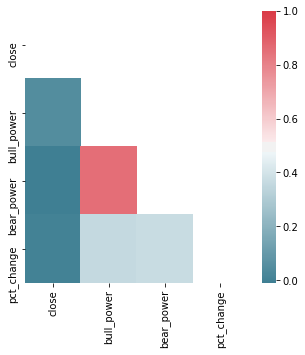

In [20]:
t = DATA[['close', 'bull_power', 'bear_power']].copy()
t['pct_change'] = t['close'].pct_change()
t.dropna(inplace=True)
corr =  t.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [21]:
def create_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [29]:
TARGET     = 'USD_CAD'
granuality = 'H1'
LOOK_BACK  = 20
SPLIT      = 0.90     # data split ration for training and testing

In [23]:
# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(DATA), columns=DATA.columns)
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(DATA.drop('high', axis=1).values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(DATA['high'].values.astype('float32').reshape(-1,1))


In [24]:
y_scaler

MinMaxScaler(copy=True, feature_range=(0, 1))

In [25]:
scaled.columns.tolist().index('high')

2

In [27]:
# Create dataset
target_index = scaled.columns.tolist().index('high')
dataset = scaled.values.astype('float32')
X, y = create_dataset(dataset, look_back=LOOK_BACK)
y = y[:,target_index]
train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [28]:
trainy.shape

(49545, 20, 15)

In [31]:
model = Sequential()
model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(20, return_sequences=True))
model.add(LSTM(10, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(4, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [79]:
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dense(4, kernel_initializer='random_uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='random_uniform', activation='relu'))

In [38]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard as tensorboard

In [80]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

In [34]:
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Enable this line if you want to monitor the trianing progress via TensorBoard
# tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
callbacks_list = [checkpoint]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
90/90 [==============================] - 4s 49ms/step - mae: 0.3917 - loss: 0.2130 - mse: 0.2130 - val_loss: 0.3523 - val_mse: 0.3523 - val_mae: 0.5347
Epoch 2/100
90/90 [==============================] - 3s 31ms/step - mae: 0.2269 - loss: 0.0701 - mse: 0.0701 - val_loss: 0.1559 - val_mse: 0.1559 - val_mae: 0.3657
Epoch 3/100
90/90 [==============================] - 3s 31ms/step - mae: 0.0786 - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0301 - val_mse: 0.0301 - val_mae: 0.1498
Epoch 4/100
90/90 [==============================] - 3s 31ms/step - mae: 0.0266 - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0111 - val_mse: 0.0111 - val_mae: 0.0892
Epoch 5/100
90/90 [==============================] - 3s 32ms/step - mae: 0.0189 - loss: 7.2704e-04 - mse: 7.2704e-04 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0599
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - mae: 0.0153 - loss: 4.2252e-04 - mse: 4.2252e-04 - val_loss: 0.0031 - val_mse: 0.0031 - val_mae: 0.0454


90/90 [==============================] - 3s 28ms/step - mae: 0.0071 - loss: 8.6283e-05 - mse: 8.6283e-05 - val_loss: 6.3281e-04 - val_mse: 6.3281e-04 - val_mae: 0.0187
Epoch 24/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0070 - loss: 8.4278e-05 - mse: 8.4278e-05 - val_loss: 6.1875e-04 - val_mse: 6.1875e-04 - val_mae: 0.0186
Epoch 25/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0068 - loss: 7.8894e-05 - mse: 7.8894e-05 - val_loss: 6.1550e-04 - val_mse: 6.1550e-04 - val_mae: 0.0185
Epoch 26/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0068 - loss: 7.9635e-05 - mse: 7.9635e-05 - val_loss: 6.1970e-04 - val_mse: 6.1970e-04 - val_mae: 0.0185
Epoch 27/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0067 - loss: 7.7469e-05 - mse: 7.7469e-05 - val_loss: 6.1907e-04 - val_mse: 6.1907e-04 - val_mae: 0.0187
Epoch 28/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0068 - loss: 8.0405e-05 - mse: 8

Epoch 45/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0056 - loss: 5.4887e-05 - mse: 5.4887e-05 - val_loss: 3.7840e-04 - val_mse: 3.7840e-04 - val_mae: 0.0148
Epoch 46/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0058 - loss: 5.7607e-05 - mse: 5.7607e-05 - val_loss: 3.5711e-04 - val_mse: 3.5711e-04 - val_mae: 0.0132
Epoch 47/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0054 - loss: 5.1142e-05 - mse: 5.1142e-05 - val_loss: 3.4692e-04 - val_mse: 3.4692e-04 - val_mae: 0.0134
Epoch 48/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0053 - loss: 4.9669e-05 - mse: 4.9669e-05 - val_loss: 3.0943e-04 - val_mse: 3.0943e-04 - val_mae: 0.0120
Epoch 49/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0053 - loss: 4.8668e-05 - mse: 4.8668e-05 - val_loss: 3.2231e-04 - val_mse: 3.2231e-04 - val_mae: 0.0130
Epoch 50/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0051 - loss: 4.6603

Epoch 67/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0051 - loss: 4.4399e-05 - mse: 4.4399e-05 - val_loss: 2.6913e-04 - val_mse: 2.6913e-04 - val_mae: 0.0114
Epoch 68/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0046 - loss: 3.8382e-05 - mse: 3.8382e-05 - val_loss: 2.5389e-04 - val_mse: 2.5389e-04 - val_mae: 0.0111
Epoch 69/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0046 - loss: 3.7830e-05 - mse: 3.7830e-05 - val_loss: 2.5179e-04 - val_mse: 2.5179e-04 - val_mae: 0.0106
Epoch 70/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0048 - loss: 4.0128e-05 - mse: 4.0128e-05 - val_loss: 2.6085e-04 - val_mse: 2.6085e-04 - val_mae: 0.0110
Epoch 71/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0046 - loss: 3.7257e-05 - mse: 3.7257e-05 - val_loss: 2.5292e-04 - val_mse: 2.5292e-04 - val_mae: 0.0107
Epoch 72/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0045 - loss: 3.6836

Epoch 89/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0044 - loss: 3.3611e-05 - mse: 3.3611e-05 - val_loss: 2.6139e-04 - val_mse: 2.6139e-04 - val_mae: 0.0115
Epoch 90/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0043 - loss: 3.2415e-05 - mse: 3.2415e-05 - val_loss: 2.5858e-04 - val_mse: 2.5858e-04 - val_mae: 0.0122
Epoch 91/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0040 - loss: 2.9499e-05 - mse: 2.9499e-05 - val_loss: 2.6536e-04 - val_mse: 2.6536e-04 - val_mae: 0.0122
Epoch 92/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0043 - loss: 3.2165e-05 - mse: 3.2165e-05 - val_loss: 2.2803e-04 - val_mse: 2.2803e-04 - val_mae: 0.0098
Epoch 93/100
90/90 [==============================] - 3s 30ms/step - mae: 0.0040 - loss: 2.8511e-05 - mse: 2.8511e-05 - val_loss: 2.2976e-04 - val_mse: 2.2976e-04 - val_mae: 0.0099
Epoch 94/100
90/90 [==============================] - 3s 29ms/step - mae: 0.0042 - loss: 3.1142

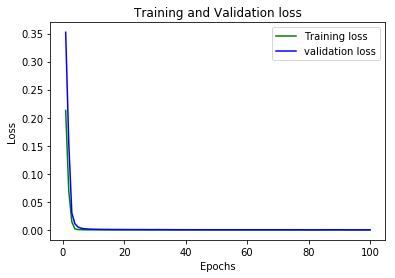

In [36]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,101)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [81]:
from keras.callbacks import LearningRateScheduler
import keras.backend as K

def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, lr_decay]
history = model.fit(trainX, trainY, epochs=100, batch_size=500, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
90/90 [==============================] - 8s 88ms/step - mae: 0.3448 - loss: 0.1740 - mse: 0.1740 - val_loss: 0.2023 - val_mse: 0.2023 - val_mae: 0.4055
Epoch 2/100
90/90 [==============================] - 7s 81ms/step - mae: 0.2190 - loss: 0.0587 - mse: 0.0587 - val_loss: 0.1557 - val_mse: 0.1557 - val_mae: 0.3670
Epoch 3/100
90/90 [==============================] - 8s 84ms/step - mae: 0.2189 - loss: 0.0583 - mse: 0.0583 - val_loss: 0.1534 - val_mse: 0.1534 - val_mae: 0.3649
Epoch 4/100
90/90 [==============================] - 8s 84ms/step - mae: 0.2189 - loss: 0.0583 - mse: 0.0583 - val_loss: 0.1541 - val_mse: 0.1541 - val_mae: 0.3655
Epoch 5/100
90/90 [==============================] - 7s 78ms/step - mae: 0.0836 - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0108 - val_mse: 0.0108 - val_mae: 0.0896
Epoch 6/100
90/90 [==============================] - 7s 77ms/step - mae: 0.0139 - loss: 4.3998e-04 - mse: 4.3998e-04 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0481
Epoch 7/

90/90 [==============================] - 7s 82ms/step - mae: 0.0064 - loss: 9.3163e-05 - mse: 9.3163e-05 - val_loss: 5.1147e-04 - val_mse: 5.1147e-04 - val_mae: 0.0161
Epoch 24/100
90/90 [==============================] - 7s 82ms/step - mae: 0.0062 - loss: 8.7347e-05 - mse: 8.7347e-05 - val_loss: 4.9690e-04 - val_mse: 4.9690e-04 - val_mae: 0.0162
Epoch 25/100
90/90 [==============================] - 7s 82ms/step - mae: 0.0062 - loss: 8.6961e-05 - mse: 8.6961e-05 - val_loss: 4.8745e-04 - val_mse: 4.8745e-04 - val_mae: 0.0158
Epoch 26/100
90/90 [==============================] - 8s 88ms/step - mae: 0.0060 - loss: 8.1666e-05 - mse: 8.1666e-05 - val_loss: 4.7070e-04 - val_mse: 4.7070e-04 - val_mae: 0.0154
Epoch 27/100
90/90 [==============================] - 8s 89ms/step - mae: 0.0058 - loss: 7.7367e-05 - mse: 7.7367e-05 - val_loss: 4.8025e-04 - val_mse: 4.8025e-04 - val_mae: 0.0159
Epoch 28/100
90/90 [==============================] - 8s 89ms/step - mae: 0.0060 - loss: 7.9860e-05 - mse: 7

Epoch 45/100
90/90 [==============================] - 8s 87ms/step - mae: 0.0047 - loss: 4.4715e-05 - mse: 4.4715e-05 - val_loss: 3.1578e-04 - val_mse: 3.1578e-04 - val_mae: 0.0121
Epoch 46/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0045 - loss: 4.1760e-05 - mse: 4.1760e-05 - val_loss: 3.0858e-04 - val_mse: 3.0858e-04 - val_mae: 0.0119
Epoch 47/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0046 - loss: 4.2167e-05 - mse: 4.2167e-05 - val_loss: 3.0731e-04 - val_mse: 3.0731e-04 - val_mae: 0.0119
Epoch 48/100
90/90 [==============================] - 7s 77ms/step - mae: 0.0046 - loss: 4.1749e-05 - mse: 4.1749e-05 - val_loss: 3.0955e-04 - val_mse: 3.0955e-04 - val_mae: 0.0120
Epoch 49/100
90/90 [==============================] - 7s 78ms/step - mae: 0.0044 - loss: 3.8821e-05 - mse: 3.8821e-05 - val_loss: 2.9854e-04 - val_mse: 2.9854e-04 - val_mae: 0.0117
Epoch 50/100
90/90 [==============================] - 8s 92ms/step - mae: 0.0045 - loss: 4.0089

90/90 [==============================] - 7s 81ms/step - mae: 0.0039 - loss: 2.8543e-05 - mse: 2.8543e-05 - val_loss: 2.6766e-04 - val_mse: 2.6766e-04 - val_mae: 0.0115
Epoch 67/100
90/90 [==============================] - 7s 79ms/step - mae: 0.0039 - loss: 2.7806e-05 - mse: 2.7806e-05 - val_loss: 2.4828e-04 - val_mse: 2.4828e-04 - val_mae: 0.0106
Epoch 68/100
90/90 [==============================] - 8s 85ms/step - mae: 0.0039 - loss: 2.8083e-05 - mse: 2.8083e-05 - val_loss: 2.4995e-04 - val_mse: 2.4995e-04 - val_mae: 0.0107
Epoch 69/100
90/90 [==============================] - 8s 85ms/step - mae: 0.0041 - loss: 3.0142e-05 - mse: 3.0142e-05 - val_loss: 2.4947e-04 - val_mse: 2.4947e-04 - val_mae: 0.0105
Epoch 70/100
90/90 [==============================] - 8s 91ms/step - mae: 0.0038 - loss: 2.6469e-05 - mse: 2.6469e-05 - val_loss: 2.4045e-04 - val_mse: 2.4045e-04 - val_mae: 0.0103
lr changed to 0.00047829695977270604
Epoch 71/100
90/90 [==============================] - 8s 90ms/step - ma

90/90 [==============================] - 7s 80ms/step - mae: 0.0034 - loss: 2.0847e-05 - mse: 2.0847e-05 - val_loss: 2.0686e-04 - val_mse: 2.0686e-04 - val_mae: 0.0092
Epoch 89/100
90/90 [==============================] - 7s 81ms/step - mae: 0.0034 - loss: 2.0786e-05 - mse: 2.0786e-05 - val_loss: 2.1533e-04 - val_mse: 2.1533e-04 - val_mae: 0.0094
Epoch 90/100
90/90 [==============================] - 7s 83ms/step - mae: 0.0033 - loss: 2.0070e-05 - mse: 2.0070e-05 - val_loss: 2.1011e-04 - val_mse: 2.1011e-04 - val_mae: 0.0098
lr changed to 0.00038742052274756136
Epoch 91/100
90/90 [==============================] - 7s 79ms/step - mae: 0.0033 - loss: 1.9953e-05 - mse: 1.9953e-05 - val_loss: 2.0231e-04 - val_mse: 2.0231e-04 - val_mae: 0.0092
Epoch 92/100
90/90 [==============================] - 7s 80ms/step - mae: 0.0033 - loss: 2.0338e-05 - mse: 2.0338e-05 - val_loss: 1.9573e-04 - val_mse: 1.9573e-04 - val_mae: 0.0091
Epoch 93/100
90/90 [==============================] - 8s 87ms/step - ma

In [82]:
pred=model.predict(testX)

In [83]:
test2=y_scaler.inverse_transform(testY.reshape(-1,1))

In [84]:
pred2=y_scaler.inverse_transform(pred.reshape(-1,1))

In [85]:
pred2

array([[19292.383],
       [19248.344],
       [19274.38 ],
       ...,
       [29605.65 ],
       [29597.336],
       [29622.723]], dtype=float32)

In [86]:
test2

array([[19055.8  ],
       [19453.25 ],
       [19483.049],
       ...,
       [29586.6  ],
       [29644.15 ],
       [29643.049]], dtype=float32)

In [87]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(test2,pred2)

In [88]:
mse

9975.965

In [51]:
dicts={"test":list(test2), 'pred': list(pred2)}

In [16]:
prices=data_10['close']
prices=np.array(prices).reshape(-1,1)
#scaling the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
close_scaled = sc.fit_transform(prices)

# Creating a data structure with 120 timesteps and 1 output

X = []
y = []


for i in range(120, len(prices)):
    X.append(close_scaled[i-120:i,:])
    y.append(close_scaled[i, 0])


X, y = np.array(X), np.array(y)
#splitting into training set and test set

lentest=int(0.15*len(prices))  
vallen=int(0.05*len(prices))
X_train=X[:len(prices)-(lentest+vallen)]
X_val=X[len(X_train):len(prices)-lentest]
X_test=X[len(prices)-lentest:]

y_train=y[:len(prices)-(lentest+vallen)]
y_val=y[len(y_train):len(prices)-lentest]
y_test=y[len(prices)-lentest:]

In [104]:
prices=data_10['close']
prices=np.array(prices).reshape(-1,1)
#scaling the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
close_scaled = sc.fit_transform(prices)

# Creating a data structure with 120 timesteps and 1 output

X = []
y = []
y_true = []

for i in range(120, len(prices)-7):
    X.append(close_scaled[i-120:i,:])
    y.append(close_scaled[i:i+7, 0])
    y_true.append(close_scaled[i, 0])


X, y, y_true = np.array(X), np.array(y), np.array(y_true)
#splitting into training set and test set

lentest=int(0.15*len(prices))
y_true_test= y_true[len(prices)-lentest:]   
vallen=int(0.05*len(prices))
X_train=X[:len(prices)-(lentest+vallen)]
X_val=X[len(X_train):len(prices)-lentest]
X_test=X[len(prices)-lentest:]

y_train=y[:len(prices)-(lentest+vallen)]
y_val=y[len(y_train):len(prices)-lentest]
y_test=y[len(prices)-lentest:]
                           

In [74]:
X_test.shape

(8138, 120, 1)

In [65]:
X_train.shape

(44080, 120, 1)

In [66]:
y_train.shape

(44080, 7)

In [75]:
y_train_dates=dates[:len(prices)-(lentest+vallen)]
y_test_dates=dates[len(prices)-lentest:]

In [76]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# # Adding a second LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 100, return_sequences = True))
# regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences=True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 30, return_sequences=False))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 7))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = regressor.fit(X_train, y_train, epochs=25, batch_size=25, validation_data=(X_val, y_val))



Epoch 1/25
1764/1764 [==============================] - 235s 133ms/step - loss: 0.0049 - val_loss: 1.6795e-04
Epoch 2/25
1764/1764 [==============================] - 240s 136ms/step - loss: 0.0011 - val_loss: 7.0721e-05
Epoch 3/25
1764/1764 [==============================] - 238s 135ms/step - loss: 8.2824e-04 - val_loss: 0.0021
Epoch 4/25
1764/1764 [==============================] - 241s 136ms/step - loss: 7.5372e-04 - val_loss: 1.7600e-04
Epoch 5/25
1764/1764 [==============================] - 241s 137ms/step - loss: 7.2996e-04 - val_loss: 0.0019
Epoch 6/25
1764/1764 [==============================] - 242s 137ms/step - loss: 7.1431e-04 - val_loss: 0.0011
Epoch 7/25
1764/1764 [==============================] - 241s 136ms/step - loss: 7.1303e-04 - val_loss: 0.0022
Epoch 8/25
1764/1764 [==============================] - 240s 136ms/step - loss: 6.8562e-04 - val_loss: 4.9785e-05
Epoch 9/25
1764/1764 [==============================] - 240s 136ms/step - loss: 6.9585e-04 - val_loss: 3.4666e-0

KeyError: 'train_loss'

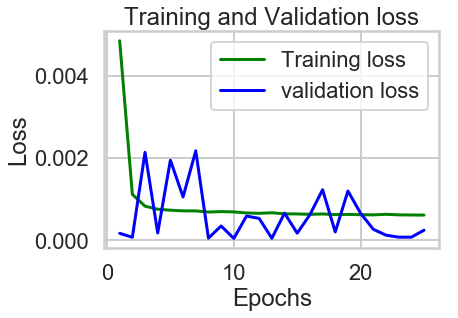

In [79]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,26)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [80]:
pred=regressor.predict(X_test)

In [81]:
pred

array([[0.9110595 , 0.91082025, 0.91144156, ..., 0.9110937 , 0.9111258 ,
        0.91044605],
       [0.91105974, 0.9108206 , 0.91144186, ..., 0.91109395, 0.911126  ,
        0.9104463 ],
       [0.9109856 , 0.91074646, 0.91136754, ..., 0.9110199 , 0.9110518 ,
        0.9103726 ],
       ...,
       [0.8470042 , 0.8467959 , 0.84735847, ..., 0.84707177, 0.84707284,
        0.84652245],
       [0.84703296, 0.84682477, 0.84738743, ..., 0.8471005 , 0.8471018 ,
        0.8465513 ],
       [0.8468195 , 0.8466114 , 0.8471738 , ..., 0.8468872 , 0.8468882 ,
        0.8463387 ]], dtype=float32)

In [86]:
for i in range(len(pred)):
    pred[i]=sc.inverse_transform(pred[i].reshape(1,-1))

In [87]:
pred

array([[30905.518, 30900.957, 30912.799, ..., 30906.168, 30906.78 ,
        30893.826],
       [30905.521, 30900.965, 30912.803, ..., 30906.174, 30906.785,
        30893.83 ],
       [30904.107, 30899.55 , 30911.387, ..., 30904.762, 30905.37 ,
        30892.426],
       ...,
       [29684.783, 29680.814, 29691.535, ..., 29686.07 , 29686.092,
        29675.602],
       [29685.33 , 29681.363, 29692.086, ..., 29686.62 , 29686.643,
        29676.152],
       [29681.264, 29677.297, 29688.016, ..., 29682.55 , 29682.572,
        29672.1  ]], dtype=float32)

In [114]:
pred[2]

array([30904.107, 30899.55 , 30911.387, 30901.703, 30904.762, 30905.37 ,
       30892.426], dtype=float32)

In [117]:
calls=[]
for i in range(len(pred)):
    p=0
    for j in range(len(pred[i])-4):
        if(pred[i][j]<pred[i][j+1]):
            p=p+1
        else:
            p=p-1
    if(p>0):
        calls.append('buy')
    elif(p<0):
        calls.append('sell')
    else:
        calls.append('neutral')
        

In [95]:
for i in range(len(y_test)):
    y_test[i]=sc.inverse_transform(y_test[i].reshape(1,-1))

In [96]:
y_test

array([[30982.75, 30959.4 , 30956.05, ..., 30937.1 , 30942.15, 30922.15],
       [30959.4 , 30956.05, 30986.7 , ..., 30942.15, 30922.15, 31005.5 ],
       [30956.05, 30986.7 , 30937.1 , ..., 30922.15, 31005.5 , 30971.8 ],
       ...,
       [29538.7 , 29515.55, 29561.4 , ..., 29556.4 , 29440.15, 29584.65],
       [29515.55, 29561.4 , 29593.4 , ..., 29440.15, 29584.65, 29611.4 ],
       [29561.4 , 29593.4 , 29556.4 , ..., 29584.65, 29611.4 , 29607.05]])

In [106]:
y_true_test=sc.inverse_transform(y_true_test.reshape(1,-1))

In [107]:
y_true_test

array([[30982.75, 30959.4 , 30956.05, ..., 29538.7 , 29515.55, 29561.4 ]])

In [26]:
pred=sc.inverse_transform(pred)
y_test=sc.inverse_transform(np.reshape(y_test,(-1,1)))
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,pred)

In [27]:
dicts={"test":list(y_test), 'pred': list(pred)}

In [52]:
df=pd.DataFrame(dicts)

In [30]:
mse

67018.01301416366

In [34]:
import seaborn as sns

In [36]:
import matplotlib.pyplot as plt

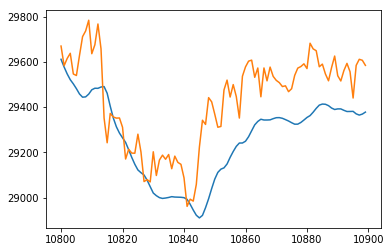

In [43]:
plt.plot(df[-100:])

In [39]:
regressor.save('my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model\assets


In [78]:
model.save("model.h5")

In [3]:
from keras.models import load_model

In [4]:
model = load_model('model.h5')

In [18]:
pred=model.predict(X_test)

In [19]:
pred=sc.inverse_transform(pred)
y_test=sc.inverse_transform(np.reshape(y_test,(-1,1)))
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,pred)

In [20]:
mse

67018.01301416366

In [53]:
df.head()

,pred,test
0,[19046.908],[19055.8]
1,[19022.133],[19453.25]
2,[19038.062],[19483.049]
3,[19058.98],[19537.898]
4,[19153.293],[19714.549]


In [27]:
len(y_test_dates[120:])

10900

In [89]:
dicts={"test":list(test2.reshape(len(test2),)), 'pred': list(pred2.reshape(len(pred2),))}

In [90]:
df=pd.DataFrame(dicts)

In [91]:
df.head(60)

,pred,test
0,19292.382812,19055.800781
1,19248.343750,19453.250000
2,19274.380859,19483.048828
3,19337.312500,19537.898438
4,19471.560547,19714.548828
5,19616.283203,19760.201172
6,19729.136719,19648.250000
7,19788.554688,19709.199219
8,19794.246094,19762.000000
9,19798.771484,19744.400391


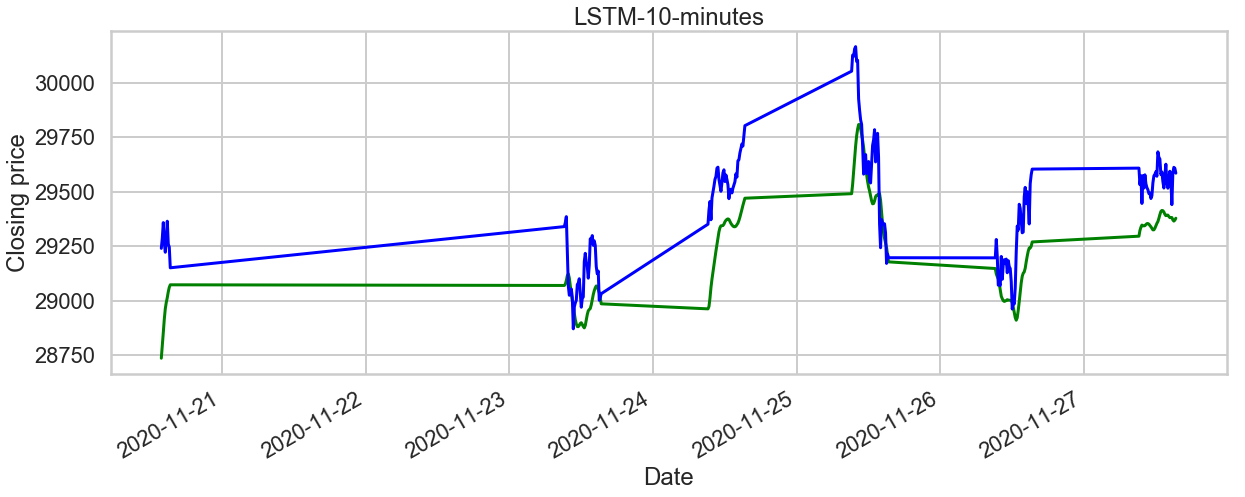

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')
fig = plt.figure(figsize = (20,7))

sns.lineplot(x = "date", y = "pred", data=df[-200:],
             palette = "hot"
             ,color="green"
            )
sns.lineplot(x = "date", y = "test", data=df[-200:],
             palette = "hot"
             ,color="blue"
            )

fig.autofmt_xdate()

plt.title("LSTM-10-minutes") # for title
plt.xlabel("Date") # label for x-axis
plt.ylabel("Closing price") # label for y-axis
plt.show()

In [92]:
df['pred_lag']=df['pred'].shift(1)

In [93]:
df['test_lag']=df['test'].shift(1)

In [94]:
df=df.dropna()

In [95]:
r=0

In [96]:
df['position'] = np.where(df['pred']> (1+r)*df['pred_lag'], 1, 0) 

In [97]:
df['position_act']= np.where(df['test']> (1+r)*df['test_lag'], 1, 0) 

In [98]:
df.head(60)

,pred,test,pred_lag,test_lag,position,position_act
1,19248.343750,19453.250000,19292.382812,19055.800781,0,1
2,19274.380859,19483.048828,19248.343750,19453.250000,1,1
3,19337.312500,19537.898438,19274.380859,19483.048828,1,1
4,19471.560547,19714.548828,19337.312500,19537.898438,1,1
5,19616.283203,19760.201172,19471.560547,19714.548828,1,1
6,19729.136719,19648.250000,19616.283203,19760.201172,1,0
7,19788.554688,19709.199219,19729.136719,19648.250000,1,1
8,19794.246094,19762.000000,19788.554688,19709.199219,1,1
9,19798.771484,19744.400391,19794.246094,19762.000000,1,0
10,19776.070312,19713.300781,19798.771484,19744.400391,0,0


In [99]:
from sklearn.metrics import accuracy_score

In [100]:
accuracy_score(df['position_act'],df['position'])

0.5389645776566757

In [ ]:
data3["strategy"] = data3["position"].shift(1) * data3["returns"]
data3.dropna(inplace=True)
data3["creturns"] = (1+data3["returns"]).cumprod()-1
data3["cstrategy"] = (1+data3["strategy"]).cumprod()-1

# absolute performance of the strategy
perf = data3["cstrategy"].iloc[-1]